In [79]:
from pyspark.sql import SparkSession

# Create a Spark session with event log configuration
spark = SparkSession.builder \
    .appName("SparkExample") \
    .config("spark.eventLog.enabled", "true") \
    .config("spark.eventLog.dir", "file:/home/jovyan/work/logs") \
    .getOrCreate()

# Continue with the rest of your PySpark code here


In [80]:
from pyspark.sql import SparkSession

# Create a Spark session with event log configuration
spark = SparkSession.builder \
    .appName("SparkExample") \
    .config("spark.eventLog.enabled", "true") \
    .config("spark.eventLog.dir", "file:/home/jovyan/work/logs") \
    .getOrCreate()

# Continue with the rest of your PySpark code here
# hadoop_namenode_address = "172.18.0.6"
hadoop_namenode_address = "namenode"
csv_path = f"hdfs://{hadoop_namenode_address}:9000/user/root/student_data/"
# HDFS path to your CSV file


# Read the CSV file into a PySpark DataFrame
df = spark.read.csv(csv_path, header=True, inferSchema=True)

# Show the DataFrame
df.show(10)

+--------------+----------------+-----------------+------+--------------------------+----------------------+-----------+----------------------+----------------------+-------------------+-------------------+---------+-------------------------+------+-----------------------+------+------------------+-----------------+-------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+-----------------+--------------+-----+--------+
|Marital status|Application mode|Application order|Course|Daytime/evening attendance|Previous qualification|Nacionality|Mother's qualification|Father's qualification|

In [81]:
# Importing Required Libraries

# Libraries required for Loading the data and for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Libraries required for Modelling and scoring
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

# Libraries to Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Librabry for Exporting Model
from joblib import dump

# To filter Warnings
import warnings

In [82]:
# Display the schema
df.printSchema()

# Display basic statistics for each column
df.describe().show()

# Count the number of rows
row_count = df.count()
print(f"Number of rows: {row_count}")

root
 |-- Marital status: integer (nullable = true)
 |-- Application mode: integer (nullable = true)
 |-- Application order: integer (nullable = true)
 |-- Course: integer (nullable = true)
 |-- Daytime/evening attendance: integer (nullable = true)
 |-- Previous qualification: integer (nullable = true)
 |-- Nacionality: integer (nullable = true)
 |-- Mother's qualification: integer (nullable = true)
 |-- Father's qualification: integer (nullable = true)
 |-- Mother's occupation: integer (nullable = true)
 |-- Father's occupation: integer (nullable = true)
 |-- Displaced: integer (nullable = true)
 |-- Educational special needs: integer (nullable = true)
 |-- Debtor: integer (nullable = true)
 |-- Tuition fees up to date: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Scholarship holder: integer (nullable = true)
 |-- Age at enrollment: integer (nullable = true)
 |-- International: integer (nullable = true)
 |-- Curricular units 1st sem (credited): integer (nullab

In [83]:
df.columns

['Marital status',
 'Application mode',
 'Application order',
 'Course',
 'Daytime/evening attendance',
 'Previous qualification',
 'Nacionality',
 "Mother's qualification",
 "Father's qualification",
 "Mother's occupation",
 "Father's occupation",
 'Displaced',
 'Educational special needs',
 'Debtor',
 'Tuition fees up to date',
 'Gender',
 'Scholarship holder',
 'Age at enrollment',
 'International',
 'Curricular units 1st sem (credited)',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (grade)',
 'Curricular units 1st sem (without evaluations)',
 'Curricular units 2nd sem (credited)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (grade)',
 'Curricular units 2nd sem (without evaluations)',
 'Unemployment rate',
 'Inflation rate',
 'GDP',
 'Target']

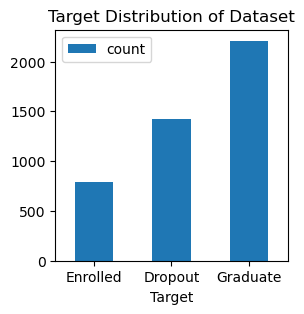

In [84]:
# Use Spark SQL to get the counts for each value in the "Target" column
target_counts = df.groupBy("Target").count().toPandas()

# Plot the bar chart using pandas
target_counts.plot(kind="bar", x="Target", y="count", figsize=(3, 3), title="Target Distribution of Dataset", rot=0)
plt.show()

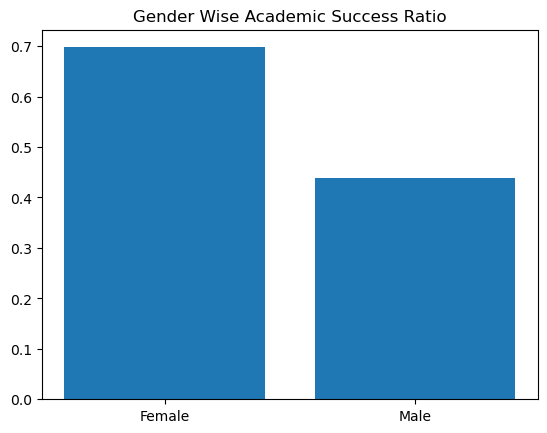

In [85]:
from pyspark.sql import functions as F
# Aggregate counts for each 'Gender' and 'Target'
gender_counts = df.groupBy("Gender", "Target").count()

# Pivot the DataFrame to get counts for each 'Target' category
pivoted_counts = gender_counts.groupBy("Gender").pivot("Target").agg(F.first("count")).fillna(0)

# Calculate proportions
pivoted_counts = pivoted_counts.withColumn("total", F.col("Graduate") + F.col("Dropout"))
proportions = pivoted_counts.withColumn("Success_percentage", F.col("Graduate") / F.col("total"))
proportions = proportions.select("Gender", "Success_percentage")

# Convert to Pandas DataFrame for plotting
proportions_pandas = proportions.toPandas()

# Plot the bar chart
plt.bar(proportions_pandas["Gender"], proportions_pandas["Success_percentage"])
plt.xticks([0, 1], ['Female', 'Male'], rotation=0)
plt.title("Gender Wise Academic Success Ratio")
plt.show()

In [86]:
# Assuming 'spark' is your SparkSession and 'df' is your PySpark DataFrame
unique_targets = df.select("Target").distinct().rdd.flatMap(lambda x: x).collect()

print(unique_targets)

['Enrolled', 'Dropout', 'Graduate']


In [87]:
from pyspark.sql.functions import when
# Mapping values in the "Target" column
df = df.withColumn("Target", when(df["Target"] == "Dropout", 0)
                            .when(df["Target"] == "Enrolled", 1)
                            .when(df["Target"] == "Graduate", 2)
                            .otherwise(df["Target"]))


In [88]:
# Get unique values from the "Target" column
unique_targets = df.select("Target").distinct()

# Convert the result to a list and print
unique_targets_list = [row.Target for row in unique_targets.collect()]
print(unique_targets_list)

['0', '1', '2']


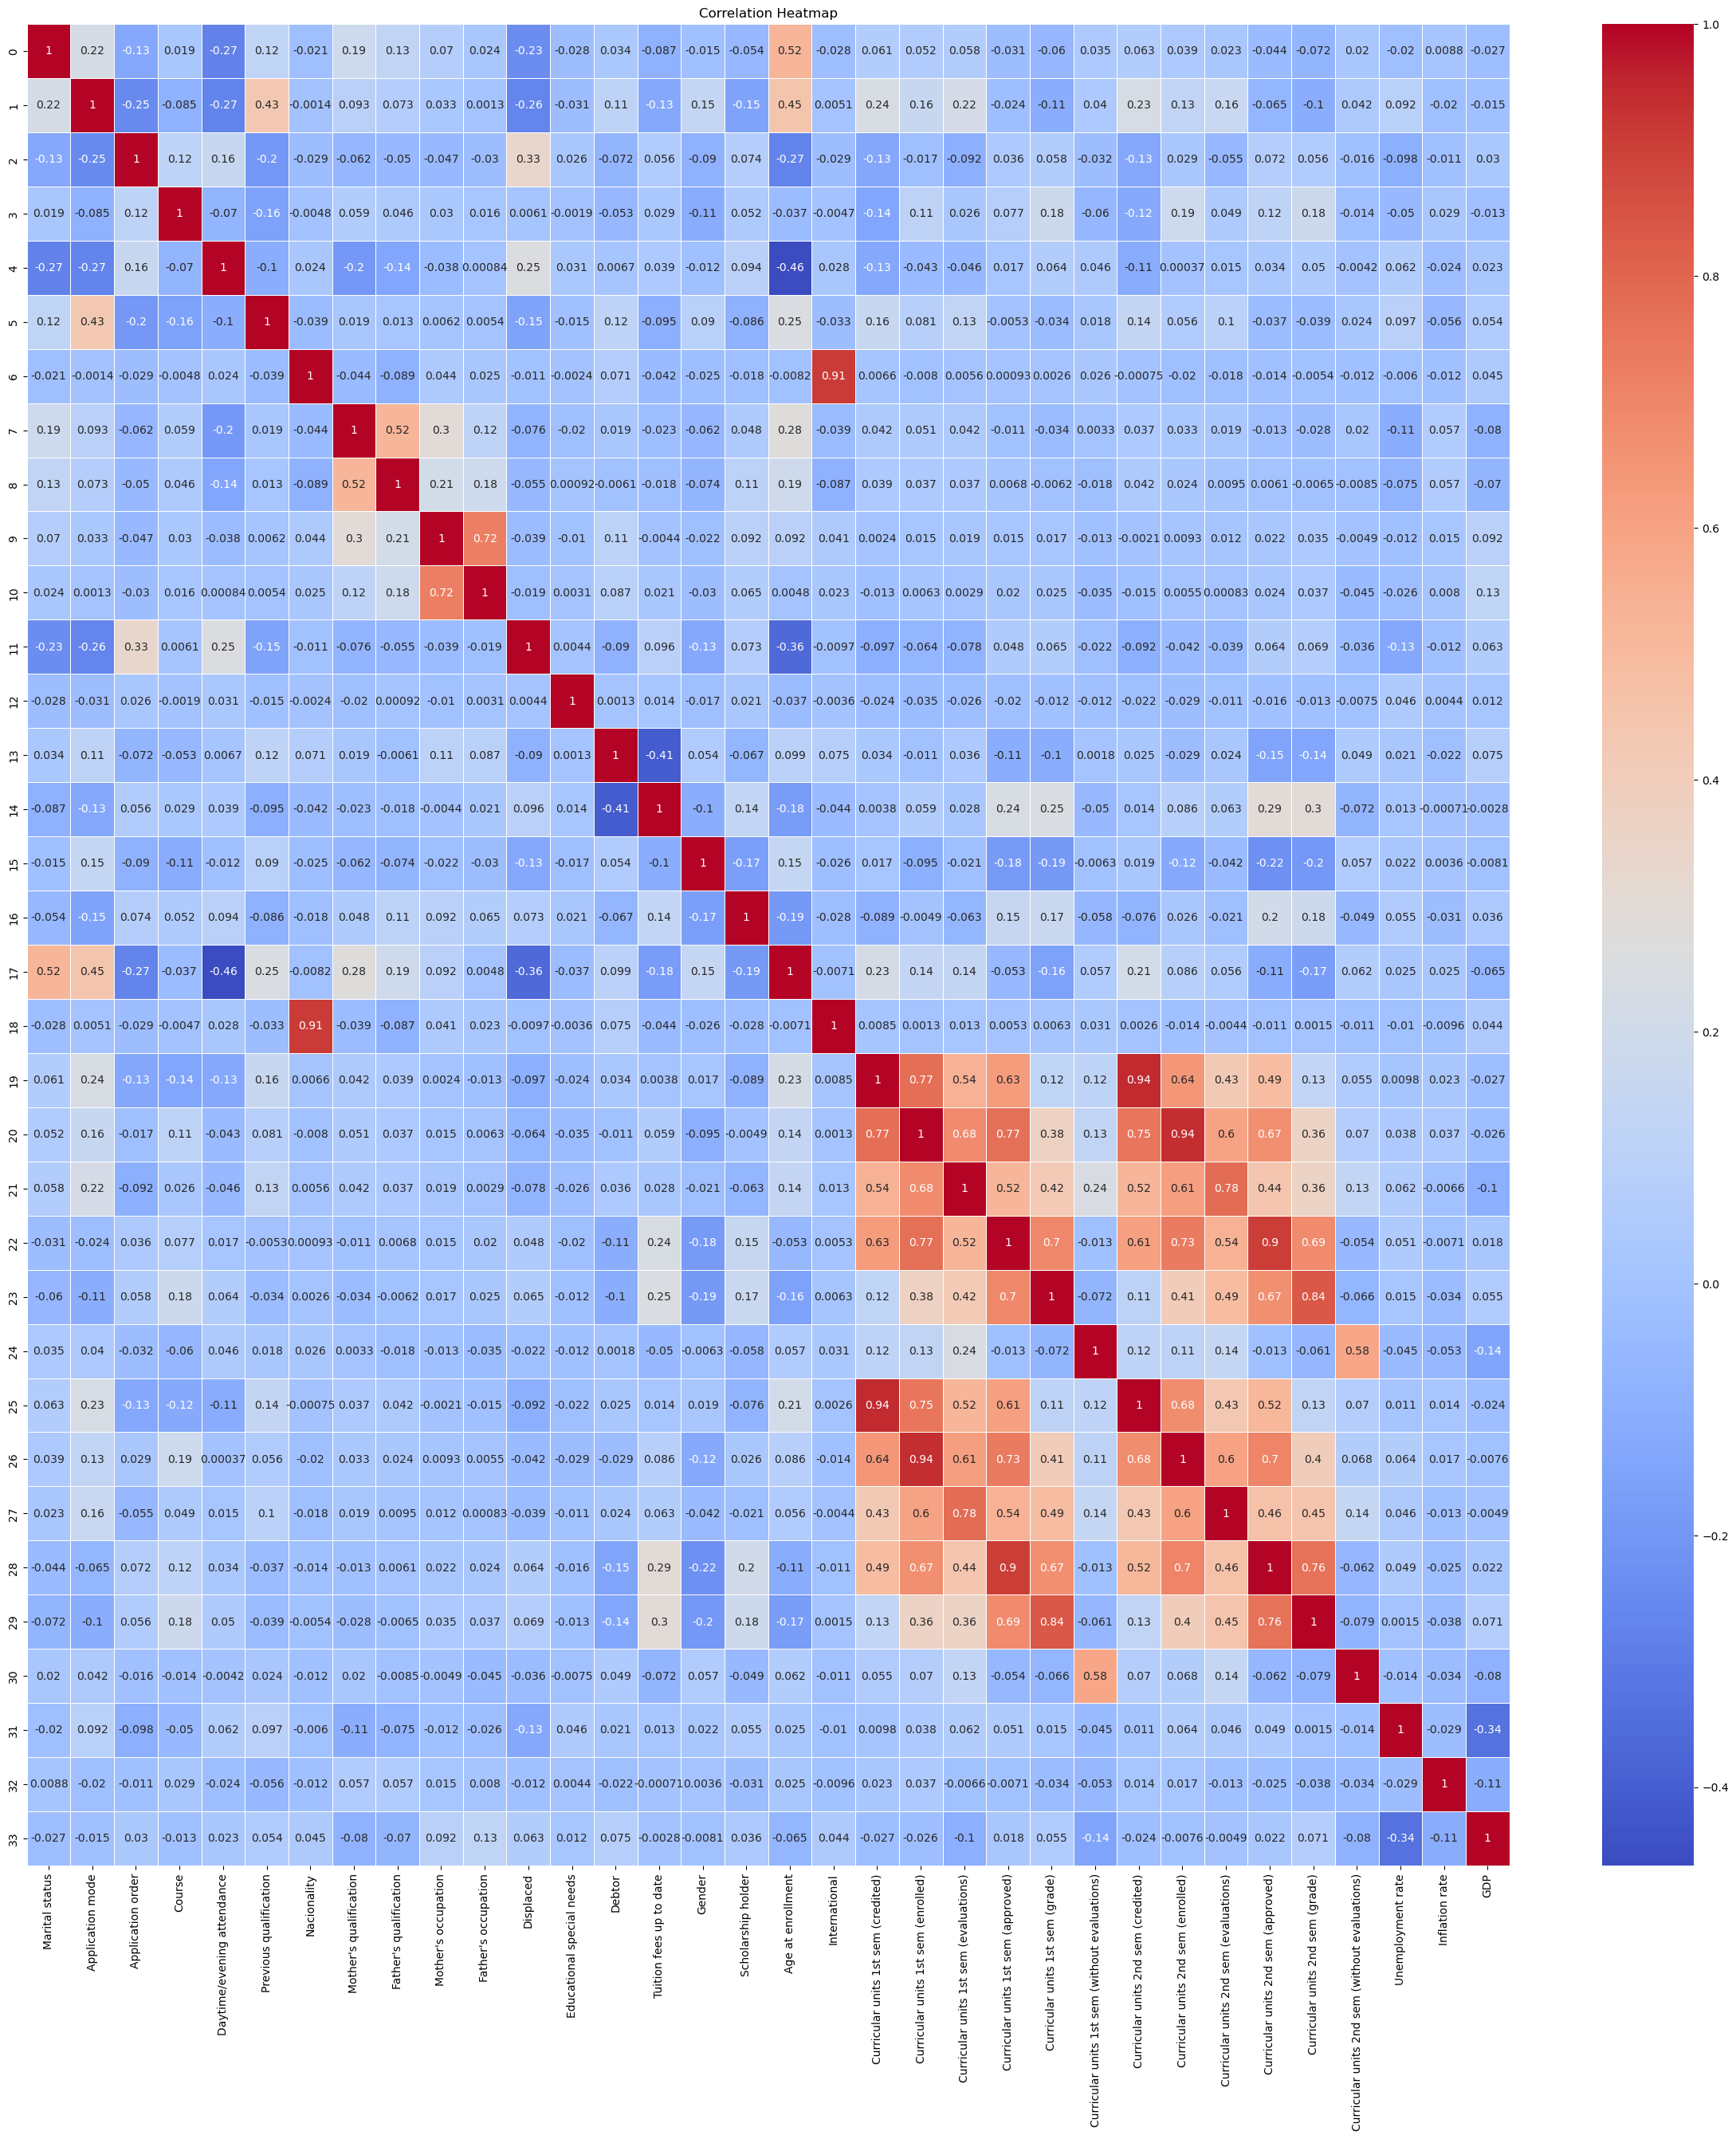

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql import SparkSession

# Assuming 'spark' is your SparkSession and 'df' is your PySpark DataFrame

# Selecting numeric columns
numeric_columns = [col_name for col_name, data_type in df.dtypes if data_type in ['int', 'double']]

# Assembling features into a vector
vector_assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
assembled_df = vector_assembler.transform(df)

# Calculating the correlation matrix
correlation_matrix = Correlation.corr(assembled_df, "features").first()[0]

# Creating a correlation matrix DataFrame
correlation_matrix_df = pd.DataFrame(correlation_matrix.toArray(), columns=numeric_columns)

# Plotting the heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [90]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Assuming 'spark' is your SparkSession and 'df' is your PySpark DataFrame

# List of columns to drop
columns_to_drop = ['Nationality',
                   'Mother\'s qualification',
                   'Father\'s qualification',
                   'Educational special needs',
                   'International',
                   'Curricular units 1st sem (without evaluations)',
                   'Unemployment rate',
                   'Inflation rate']

# Creating a new DataFrame with the specified columns dropped
new_df = df.select([col(column) for column in df.columns if column not in columns_to_drop])

# Displaying the schema of the new DataFrame
new_df.printSchema()

root
 |-- Marital status: integer (nullable = true)
 |-- Application mode: integer (nullable = true)
 |-- Application order: integer (nullable = true)
 |-- Course: integer (nullable = true)
 |-- Daytime/evening attendance: integer (nullable = true)
 |-- Previous qualification: integer (nullable = true)
 |-- Nacionality: integer (nullable = true)
 |-- Mother's occupation: integer (nullable = true)
 |-- Father's occupation: integer (nullable = true)
 |-- Displaced: integer (nullable = true)
 |-- Debtor: integer (nullable = true)
 |-- Tuition fees up to date: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Scholarship holder: integer (nullable = true)
 |-- Age at enrollment: integer (nullable = true)
 |-- Curricular units 1st sem (credited): integer (nullable = true)
 |-- Curricular units 1st sem (enrolled): integer (nullable = true)
 |-- Curricular units 1st sem (evaluations): integer (nullable = true)
 |-- Curricular units 1st sem (approved): integer (nullable = tr

In [91]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count

# Assuming 'spark' is your SparkSession and 'df' is your PySpark DataFrame

# Grouping by the "Target" column and counting occurrences
target_counts = df.groupBy("Target").agg(count("*").alias("Count"))

# Displaying the value counts
target_counts.show()

+------+-----+
|Target|Count|
+------+-----+
|     0| 1421|
|     1|  794|
|     2| 2209|
+------+-----+



In [92]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assuming 'spark' is your SparkSession
# spark = SparkSession.builder.appName("YourAppName").getOrCreate()

# Assuming 'new_df' is your PySpark DataFrame
# Drop the existing "features" column if it exists
if "features" in new_df.columns:
    new_df = new_df.drop("features")
if "label" in new_df.columns:
    new_df = new_df.drop("label")

# Convert the 'Target' column to numeric using StringIndexer
target_indexer = StringIndexer(inputCol="Target", outputCol="label")
new_df = target_indexer.fit(new_df).transform(new_df)

# Assemble features into a single vector column
feature_cols = [col for col in new_df.columns if col != "Target" and col != "label"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
new_df = assembler.transform(new_df)

# Split the data into training and testing sets
train_data, test_data = new_df.randomSplit([0.8, 0.2], seed=0)

# Assuming 'RandomForestClassifier' is your classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label")

# Assuming 'paramGrid' is your parameter grid for tuning
paramGrid = ParamGridBuilder().build()

# Assuming 'evaluator' is your evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Assuming 'pipeline' is your pipeline
pipeline = Pipeline(stages=[rf])

# Assuming 'cv' is your CrossValidator
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Fit the model
cv_model = cv.fit(train_data)

# Make predictions on the test data
predictions = cv_model.transform(test_data)

# Evaluate accuracy
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Stop the Spark session
# spark.stop()


Accuracy: 0.7391774891774892


In [108]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StringIndexer


In [109]:
# Assuming 'new_df' is your PySpark DataFrame
# Drop the existing "features" column if it exists
if "features" in new_df.columns:
    new_df = new_df.drop("features")
if "label" in new_df.columns:
    new_df = new_df.drop("label")

# Convert the 'Target' column to numeric using StringIndexer
target_indexer = StringIndexer(inputCol="Target", outputCol="label")
new_df = target_indexer.fit(new_df).transform(new_df)

# Assemble features into a single vector column
feature_cols = [col for col in new_df.columns if col != "Target" and col != "label"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
new_df = assembler.transform(new_df)

# Split the data into training and testing sets
train_data, test_data = new_df.randomSplit([0.8, 0.2], seed=0)


In [114]:
# Assuming 'RandomForestClassifier' is your first classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", predictionCol="rf_prediction", rawPredictionCol="rf_rawPrediction")

# Assuming 'paramGridRF' is your parameter grid for Random Forest tuning
paramGridRF = ParamGridBuilder().build()

# Assuming 'evaluator' is your evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="rf_prediction", metricName="accuracy")

# Assuming 'pipeline' is your pipeline
pipeline = Pipeline(stages=[rf])

# Assuming 'cv' is your CrossValidator
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGridRF, evaluator=evaluator, numFolds=5)

# Fit the model
cv_model = cv.fit(train_data)

# Make predictions on the test data
predictions = cv_model.transform(test_data)

# Evaluate accuracy
accuracy = evaluator.evaluate(predictions)
print(f"Random Forest Accuracy: {accuracy}")


Random Forest Accuracy: 0.7391774891774892
